# Loop fitting H$_2$O and Silicate areas from unexposed MIs
- This notebook shows how to quantify the relative area of the silicate peak and H$_2$O peak from acquisitions of olivine-hosted melt inclusions still at depth in the crystal. Specifically, the code unmixes the olivine and melt inclusions spectra to obtain the glass spectra
- In this example, we fit each file individually

### Install DiadFit if you havent already- uncomment this!

In [1]:
#!pip install --upgrade DiadFit

## Import necessary python things

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.91'

In [3]:
# This is where you tell the code where your spectra are. E.g. DayFolder is the overal folder, if you have subfolders for Spectra and MetaData
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
file_ext='.txt'
filetype='Witec_ASCII'

In [4]:
# Get the files which are the melt inclusion/H2O acquisitoin first. You need a unique string (here H2O) which is in all files
MI_Files=pf.get_files(path=spectra_path,
file_ext=file_ext, ID_str='H2O', 
exclude_str=['depth', 'line', 'scan'], sort=False)
MI_Files

['02 CC14_MI2_H2O_96mw.txt',
 '05 CC13_MI4_H2O.txt',
 '09 CC9_MI3_H2O.txt',
 '12 CC9_MI1_H2O_20X.txt',
 '15 CC9_MI1_H2O_50X.txt',
 '18 CC5_MI1_H2O_10mw.txt',
 '21 CC7_MI3_H2O.txt',
 '24 CC4_MI1_H2O.txt',
 '29 MS13_2_MI1_H2O.txt']

In [5]:
# These are the files for the acquisition in the neighbouring host mineral - in this case, the unique file string is 'Ol'
Host_Files=pf.get_files(path=spectra_path,
file_ext=file_ext, ID_str='Ol',
exclude_str=['depth', 'line', 'scan'], sort=False)
Host_Files

['03 CC14_MI2_Ol_96mw.txt',
 '06 CC13_MI4_Ol.txt',
 '10 CC9_MI3_Ol.txt',
 '16 CC9_MI1_Ol_50X.txt',
 '19 CC5_MI1_Ol.txt',
 '22 CC7_MI3_Ol.txt',
 '25 CC4_MI1_Ol.txt',
 '30 MS13_2_MI1_Ol.txt']

## In future, we will add a way to remove Cosmic rays here

### Look at what is required to split up, and where xstal vs MI name are


In [6]:
print(Host_Files[0].split('_'))

['03 CC14', 'MI2', 'Ol', '96mw.txt']


In [7]:
# Here you define what characters separate MI and crystal names
pos_crystal=0 
pos_MI=1
char_crystal='_'
char_MI='_'
Host_Files_extract=pf.extract_xstal_MI_name(files=Host_Files, prefix=True, str_prefix=' ',
char_xstal=char_crystal, pos_xstal=pos_crystal, char_MI=char_MI, pos_MI=pos_MI, file_ext=file_ext)
Host_Files_extract.head()

good job, no duplicate file names


,filename,crystal_name,MI_name
0,03 CC14_MI2_Ol_96mw.txt,CC14,MI2
1,06 CC13_MI4_Ol.txt,CC13,MI4
2,10 CC9_MI3_Ol.txt,CC9,MI3
3,16 CC9_MI1_Ol_50X.txt,CC9,MI1
4,19 CC5_MI1_Ol.txt,CC5,MI1


In [8]:
print(MI_Files[0].split('_'))

['02 CC14', 'MI2', 'H2O', '96mw.txt']


In [9]:
MI_Files_extract=pf.extract_xstal_MI_name(files=MI_Files,prefix=True, str_prefix=' ',
char_xstal=char_crystal, pos_xstal=pos_crystal, char_MI=char_MI, pos_MI=pos_MI)
MI_Files_extract.head()

good job, no duplicate file names


,filename,crystal_name,MI_name
0,02 CC14_MI2_H2O_96mw.txt,CC14,MI2
1,05 CC13_MI4_H2O.txt,CC13,MI4
2,09 CC9_MI3_H2O.txt,CC9,MI3
3,12 CC9_MI1_H2O_20X.txt,CC9,MI1
4,15 CC9_MI1_H2O_50X.txt,CC9,MI1


In [10]:
# This aligns the H2O and silicate file based on the same value for the column xstal name and MI name
merge=MI_Files_extract.merge(Host_Files_extract, on=['crystal_name', 'MI_name' ], how='inner')
merge.head()

,filename_x,crystal_name,MI_name,filename_y
0,02 CC14_MI2_H2O_96mw.txt,CC14,MI2,03 CC14_MI2_Ol_96mw.txt
1,05 CC13_MI4_H2O.txt,CC13,MI4,06 CC13_MI4_Ol.txt
2,09 CC9_MI3_H2O.txt,CC9,MI3,10 CC9_MI3_Ol.txt
3,12 CC9_MI1_H2O_20X.txt,CC9,MI1,16 CC9_MI1_Ol_50X.txt
4,15 CC9_MI1_H2O_50X.txt,CC9,MI1,16 CC9_MI1_Ol_50X.txt


### Select file
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
- Come back to here and change the i value

In [11]:
print('max i value='+str(len(merge)-1))

max i value=8


In [12]:
# Just choose 1 file to have a look
i=0
filename_MI=merge['filename_x'].iloc[i]
filename_Host=merge['filename_y'].iloc[i]
print(merge['filename_y'].iloc[i])

03 CC14_MI2_Ol_96mw.txt


In [13]:
# This pulls out the host file and the MI file
spectra_Host=pf.get_data(path=spectra_path, filename=filename_Host,
            Diad_files=None, filetype=filetype)

spectra_MI=pf.get_data(path=spectra_path, filename=filename_MI,
            Diad_files=None, filetype=filetype)

## First plot spectra

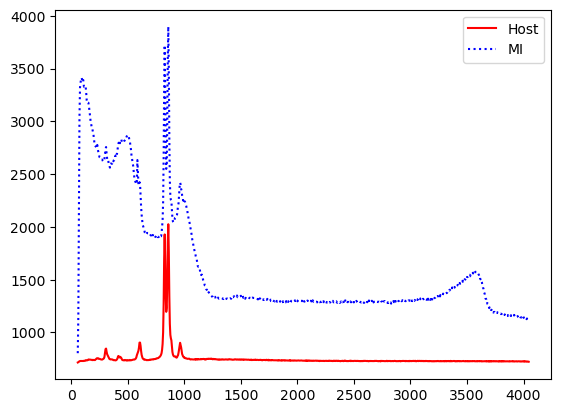

In [14]:
plt.plot(spectra_Host[:, 0], spectra_Host[:,1], '-r', label='Host')
plt.plot(spectra_MI[:, 0], spectra_MI[:,1], ':b', label='MI')
plt.legend()

### Now, lets smooth and trim the spectra, and find the peaks

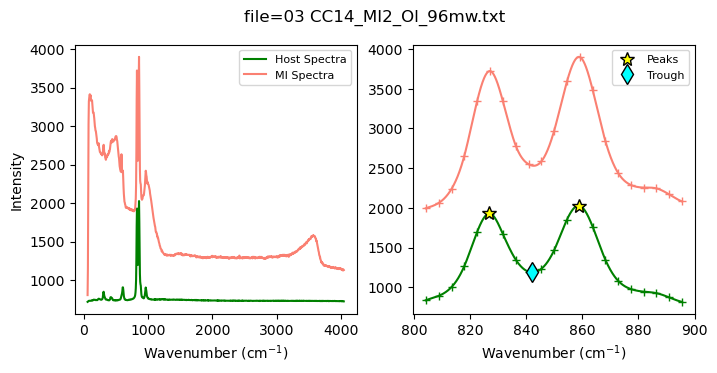

In [15]:
x_new, y_cub_MI, y_cub_Host, peak_pos_Host, peak_height_Host, trough_x, trough_y, fig=pf.smooth_and_trim_around_host(
x_range=[800,900], x_max=900, Host_spectra=spectra_Host,
MI_spectra=spectra_MI, filename=filename_Host)
fig.savefig('smooth_Spline.png', dpi=300, bbox_inches='tight')

## Now lets look at different mixing proportions

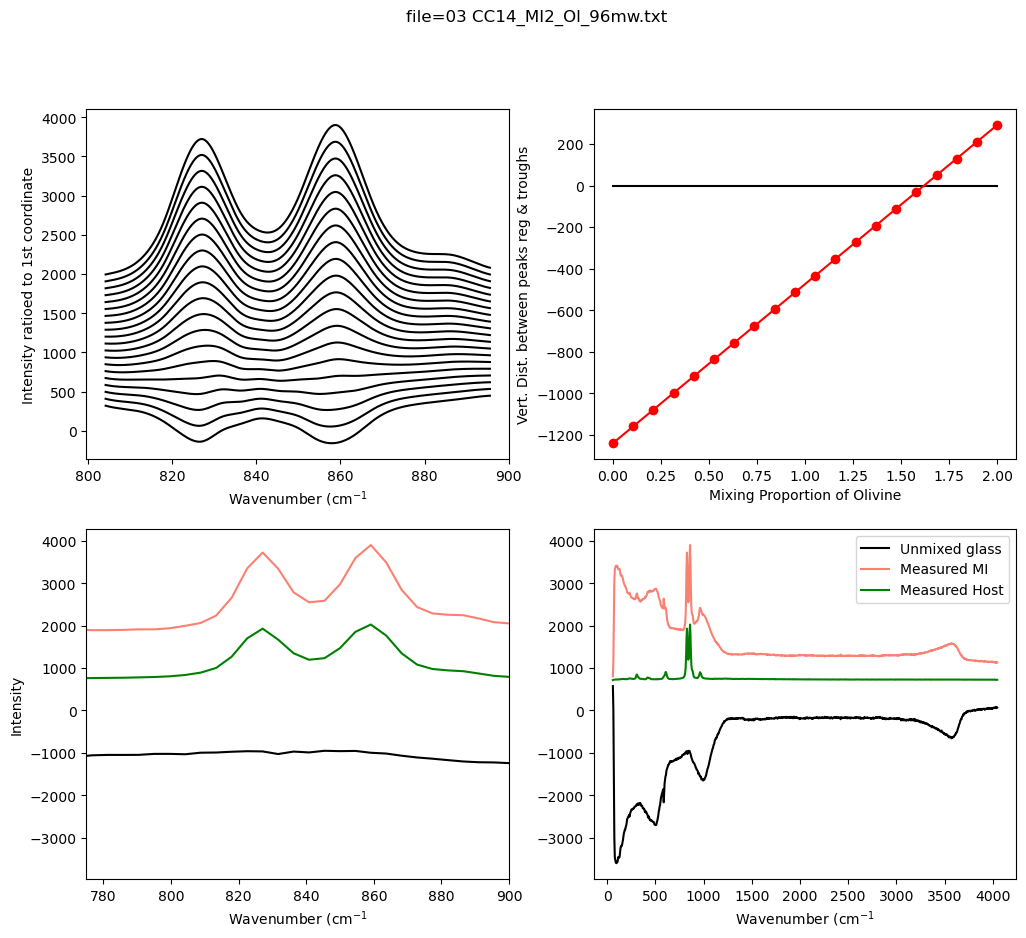

In [16]:
MI_Mix_Best, ideal_mix, Dist, MI_Mix, X=pf.make_evaluate_mixed_spectra(
path=spectra_path, filename=filename_Host,
smoothed_host_y=y_cub_Host, smoothed_MI_y=y_cub_MI,
Host_spectra=spectra_Host, MI_spectra=spectra_MI, x_new=x_new, 
peak_pos_Host= peak_pos_Host,
trough_x=trough_x, trough_y=trough_y, N_steps=20, av_width=2,
X_min=0, X_max=2)

### check if spectra needs inverting
- Sometimes the best fit spectra will end up upsideown, this inverts it if this happens

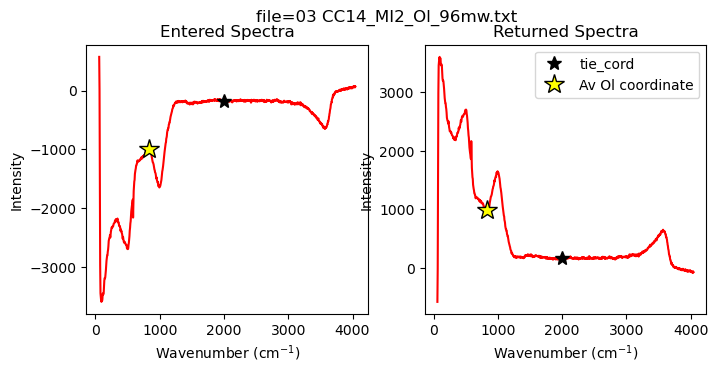

In [17]:
Spectra2=pf.check_if_spectra_negative(Spectra=MI_Mix_Best, 
path=spectra_path, filename=filename_Host,
peak_pos_Host=peak_pos_Host, tie_x_cord=2000, override=False, flip=True)

## Now lets quantify the area under the silicate region

- Set up the background postiions, can overwrite default

In [18]:
config_silicate=pf.sil_bck_pos_Schiavi_basalt(
lower_range_sil=(200, 320),
mid_range1_sil=(640, 670), mid_range2_sil=(800, 860),
upper_range_sil=(1200, 1300),
N_poly_sil=5)

sil_bck_pos_Schiavi_basalt(lower_range_sil=(200, 320), mid_range1_sil=(640, 670), mid_range2_sil=(800, 860), upper_range_sil=(1200, 1300), LW=(400, 600), HW=(800, 1200), N_poly_sil=5, sigma_sil=5)


,Silicate_LHS_Back1,Silicate_LHS_Back2,Silicate_RHS_Back1,Silicate_RHS_Back2,Silicate_N_Poly,Silicate_Trapezoid_Area,Silicate_Simpson_Area,LW_Silicate_Trapezoid_Area,LW_Silicate_Simpson_Area,HW_Silicate_Trapezoid_Area,HW_Silicate_Simpson_Area,MW_Silicate_Trapezoid_Area,MW_Silicate_Simpson_Area
0,200,320,1200,1300,5,379864.496263,379745.013178,198303.832398,198693.030414,198303.832398,198693.030414,2856.492903,2889.766264


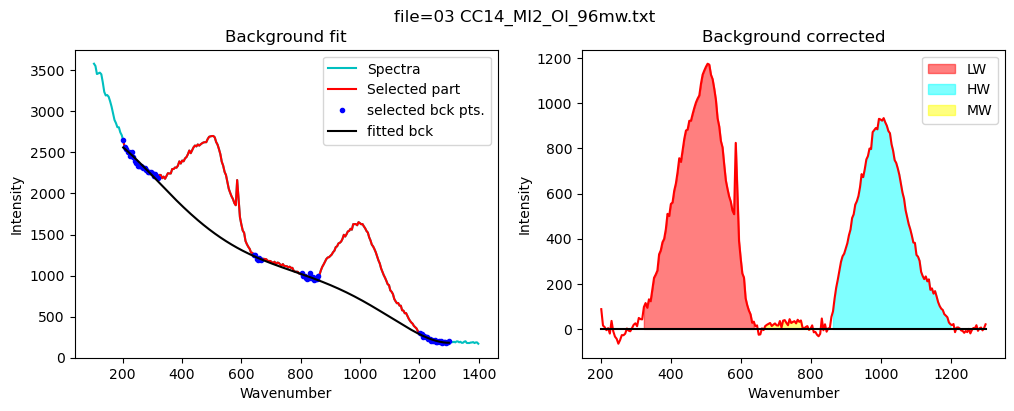

In [19]:

print(config_silicate)
df_sil=pf.fit_area_for_silicate_region(Spectra=Spectra2, 
path=spectra_path, filename=filename_Host, config1=config_silicate, 
 plot_figure=True,
fit_sil='poly')
df_sil

## Now quantify the area under the water region

water_bck_pos(fit_water='poly', N_poly_water=2, lower_bck_water=(2400, 2750), upper_bck_water=(3750, 4100))


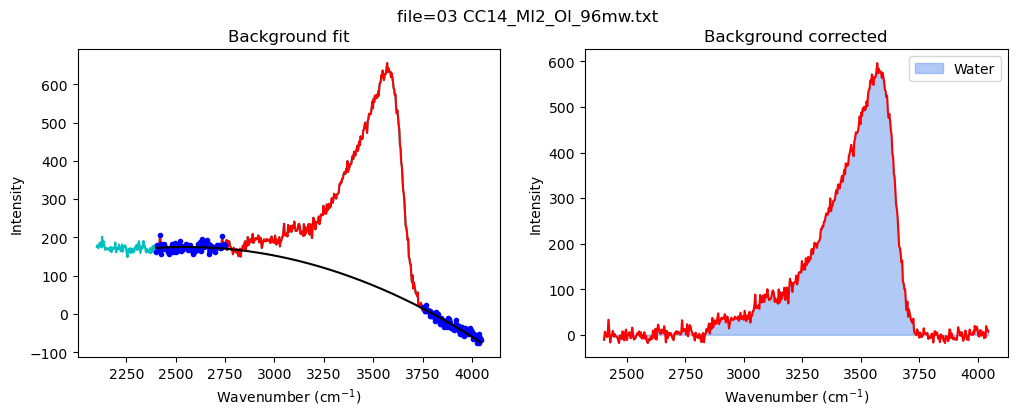

In [20]:
config_MI=pf.water_bck_pos(lower_bck_water=(2400, 2750),
N_poly_water=2)
print(config_MI)
df_H2O=pf.fit_area_for_water_region(
path=spectra_path, filename=filename_Host,
Spectra=Spectra2, config1=config_MI, plot_figure=True)

In [21]:
combo_out=pf.stitch_dataframes_together(path=DayFolder, df_sil=df_sil, df_water=df_H2O, 
Host_file=filename_Host, MI_file=filename_MI, save_csv=True)
combo_out

,Host filename,MI filename,HW:LW_Trapezoid,HW:LW_Simpson,Water_Trapezoid_Area,Water_Simpson_Area,Silicate_Trapezoid_Area,Silicate_Simpson_Area,Silicate_LHS_Back1,Silicate_LHS_Back2,...,HW_Silicate_Trapezoid_Area,HW_Silicate_Simpson_Area,MW_Silicate_Trapezoid_Area,MW_Silicate_Simpson_Area,Water Filename,Water_LHS_Back1,Water_LHS_Back2,Water_RHS_Back1,Water_RHS_Back2,Water_N_Poly
0,03 CC14_MI2_Ol_96mw.txt,02 CC14_MI2_H2O_96mw.txt,1.065692,1.062774,211330.717146,211165.80878,379864.496263,379745.013178,200,320,...,198303.832398,198693.030414,2856.492903,2889.766264,03 CC14_MI2_Ol_96mw.txt,2400,2750,3750,4100,2


## Click this to go back to the point where you change i

[Select file](#Select-file)

In [22]:
csv_files2=pf.get_files(path=os.getcwd(), ID_str='Ol-H2O',
    sort=True, file_ext='csv')
csv_files2

['Ol-H2O combo, file0.csv',
 'Ol-H2O combo, file1.csv',
 'Ol-H2O combo, file2.csv',
 'Ol-H2O combo, file3.csv',
 'Ol-H2O combo, file4.csv',
 'Ol-H2O combo, file5.csv',
 'Ol-H2O combo, file6.csv',
 'Ol-H2O combo, file7.csv',
 'Ol-H2O combo, file8.csv']

In [23]:
df = pd.concat(
    map(pd.read_csv, csv_files2), ignore_index=True)
df

,Unnamed: 0,Olivine filename,MI filename,H2O_vs_Silicate_Area_Trapezoid,H2O_vs_Silicate_Area_Simpson,Water_Trapezoid_Area,Water_Simpson_Area,Silicate_Trapezoid_Area,Silicate_Simpson_Area,Silicate_LHS_Back1,...,Host filename,HW:LW_Trapezoid,HW:LW_Simpson,LW_Silicate_Trapezoid_Area,LW_Silicate_Simpson_Area,HW_Silicate_Trapezoid_Area,HW_Silicate_Simpson_Area,MW_Silicate_Trapezoid_Area,MW_Silicate_Simpson_Area,Water Filename
0,0,03 CC14_MI2_Ol_96mw.txt,02 CC14_MI2_H2O_96mw.txt,0.385033,0.384900,2.110401e+05,2.109270e+05,5.481086e+05,5.480040e+05,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,05 CC13_MI4_H2O.txt,NaN,NaN,1.599166e+05,1.599021e+05,3.528897e+05,3.529956e+05,190,...,06 CC13_MI4_Ol.txt,0.734731,0.733601,217653.306279,217968.828298,217653.306279,217968.828298,-198.998756,-132.670940,06 CC13_MI4_Ol.txt
2,0,NaN,09 CC9_MI3_H2O.txt,NaN,NaN,3.014613e+05,3.015301e+05,5.760813e+05,5.755996e+05,190,...,10 CC9_MI3_Ol.txt,0.939945,0.940443,320722.192476,320625.755483,320722.192476,320625.755483,-560.096605,-774.983948,10 CC9_MI3_Ol.txt
3,0,16 CC9_MI1_Ol_50X.txt,12 CC9_MI1_H2O_20X.txt,0.691097,0.691153,2.659896e+05,2.659791e+05,3.848804e+05,3.848337e+05,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,16 CC9_MI1_Ol_50X.txt,15 CC9_MI1_H2O_50X.txt,0.415320,0.415619,2.006706e+05,2.007565e+05,4.831707e+05,4.830299e+05,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,19 CC5_MI1_Ol.txt,18 CC5_MI1_H2O_10mw.txt,0.472119,0.472046,4.406210e+05,4.402918e+05,9.332830e+05,9.327305e+05,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,22 CC7_MI3_Ol.txt,21 CC7_MI3_H2O.txt,0.358982,0.358259,3.399705e+05,3.393829e+05,9.470408e+05,9.473115e+05,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,25 CC4_MI1_Ol.txt,24 CC4_MI1_H2O.txt,0.450871,0.451595,3.800482e+06,3.803850e+06,8.429201e+06,8.423140e+06,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,30 MS13_2_MI1_Ol.txt,29 MS13_2_MI1_H2O.txt,0.096652,0.096509,8.935362e+04,8.907472e+04,9.244899e+05,9.229682e+05,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
